In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain.tools import tool
from typing import List, Optional, Annotated
from langgraph.graph import MessagesState
import operator
from typing_extensions import TypedDict
from pprint import pprint


class TaskStep(BaseModel):
    """
    Model for a task step in the research process.
    Types:
      - "search": Retrieve raw information from the web.
      - "think": (Optional) Further analyze or refine extracted data from search.
      - "respond": Generate the final answer.
    """

    id: str = Field(description="Unique identifier for the step")
    description: str = Field(
        description='Step description, e.g., "Search for latest AI news"'
    )
    status: Literal["pending", "in_progress", "completed"] = Field(
        description='Step status: "pending", "in_progress", or "completed"'
    )
    type: Literal["search", "think", "respond"] = Field(
        description='Step type: "search", "think", or "respond"'
    )
    data: dict = Field(default_factory=dict, description="Additional data for the step")
    search_result: Optional[List] = Field(description="The search result")
    result: Optional[List] = Field(description="The result of the step")


class TaskSteps(BaseModel):
    """
    Model for a list of task steps.
    """

    steps: List[TaskStep] = Field(description="List of task steps")


class Reference(BaseModel):
    """
    Schema for a reference
    """

    citation_id: int = Field(description="The citation id starting from 1.")
    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")


class FinalResponse(BaseModel):
    """
    Schema for the final response.
    """

    markdown: str = Field(
        description="The markdown formatted final response with inline citations. If you add any headings, make sure to start at level (##)."
    )
    references: list[Reference] = Field(description="A list of references.")

In [3]:
class AgentState(MessagesState):
    """
    The state of the agent.
    Contains the model identifier, a list of steps, and the final answer.
    """

    steps: Annotated[list, operator.add]
    search_result: Annotated[str, operator.add]
    extraction_result: Optional[str]
    think_result: Optional[str]
    answer: Optional[str]


class WorkerState(TypedDict):
    steps: Annotated[list, operator.add]
    current_step: TaskStep

In [4]:
from langchain_openai import ChatOpenAI

smart_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
fast_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

In [5]:
from datetime import datetime
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig


async def plan_steps_node(state: AgentState, config: RunnableConfig):
    """
    Generate a plan of steps for the research process.
    The plan should include steps of type "search", and "respond".
    Optionally, a "think" step may be included if further analysis is desired.
    """
    instructions = f"""
You are an assistant specialized in breaking down complex queries into actionable steps.

Generate a plan of steps to find the answer to the user's query.
If the query is simple, you may directly create one "respond" step.

Divide the query into the following steps:
- First, create one or more "search" steps to retrieve raw information from the web.
- Optionally, create a "think" step to analyze the extracted data further.
- Finally, create a "respond" step to generate the final answer in markdown format.

Current date: {datetime.now().strftime("%Y-%m-%d")}.
"""
    response = await smart_model.with_structured_output(TaskSteps).ainvoke(
        [
            SystemMessage(content=instructions),
            HumanMessage(
                content=state["messages"][0].content,
            ),
        ],
        config,
    )

    return {"steps": response.steps}

In [6]:
import json
import asyncio
from datetime import datetime
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import SystemMessage, HumanMessage


async def search_node(state: WorkerState, config: RunnableConfig):
    """
    Execute a pending "search" step.
    This node generates multiple search queries for the current step and then invokes
    the Tavily search tool for each query. The results are aggregated and stored in the current step's data.
    """

    # Initialize the Tavily search tool
    tavily_tool = TavilySearchResults(
        max_results=3,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=False,
    )

    # Retrieve the steps list and current step from WorkerState
    steps_list = state.get("steps", [])
    current_step = state.get("current_step")
    if current_step is None:
        raise ValueError("No pending search step found in WorkerState.")

    # Prepare system and human instructions for generating multiple queries
    system_instructions = f"""
You are an AI assistant specialized in generating search queries.
Based on the following step description, generate multiple relevant search queries.
Current date: {datetime.now().strftime("%Y-%m-%d")}.
"""
    human_instructions = f"Current step: {current_step.description}"

    # Bind the search tool to the model and invoke it with the messages
    model = smart_model.bind_tools([tavily_tool], tool_choice=tavily_tool.name)
    response = await model.ainvoke(
        [
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )

    tool_msg = await tavily_tool.ainvoke(response.tool_calls[0])
    current_step.status = "completed"

    return {"search_result": tool_msg.content}

In [7]:
async def extraction_node(state: AgentState, config: RunnableConfig):
    """
    Extract and summarize key information from raw search results.
    This node should run immediately after a search step.
    """
    print("\n\n\n\n")
    pprint(state)
    print("\n\n\n\n")

    raw_search_results = state["search_result"]
    system_instructions = f"""
You are an assistant that summarizes raw search results.
Please extract and summarize the relevant information, including key data and reference links.
DO NOT INCLUDE ANY EXTRA INFORMATION. ALL OF THE INFORMATION YOU ARE LOOKING FOR IS IN THE SEARCH RESULTS.
DO NOT answer the user's query yet. Just summarize the search results.

Use markdown formatting and put the references inline and the links at the end.
Like this:
This is a sentence with a reference to a source[1] and another reference[2].
[1]: [Title of Source 1](http://example.com/source1)
[2]: [Title of Source 2](http://example.com/source2)
"""
    human_instructions = f"Raw search results: {raw_search_results}"
    response = await fast_model.ainvoke(
        [
            state["messages"][0].content,
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )

    return {"extracton_result": response.content}

In [8]:
async def think_node(state: AgentState, config: RunnableConfig):
    """
    Optionally process the extracted information for further analysis.
    This node is executed if there is a pending "think" step.
    """
    steps_list = state.get("steps", [])
    current_step = next(
        (
            step
            for step in steps_list
            if step.status == "pending" and step.type == "think"
        ),
        None,
    )

    print(current_step)

    # System and Human Instructions
    system_instructions = """
You are an advanced reasoning AI designed to analyze and refine information.
Carefully evaluate the provided data to enhance its clarity and completeness.
"""

    human_instructions = f"""
Based on the following extracted data:
{steps_list}
Please analyze and refine the information before generating the final answer.
"""

    response = await fast_model.ainvoke(
        [
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )

    # Update the current step using dictionary assignment
    current_step.status = "completed"
    return {"think_result": response.content}

In [9]:
import json
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool
from pydantic import BaseModel, Field


async def response_node(state: AgentState, config: RunnableConfig):
    """
    Generate the final answer using the aggregated information.
    """

    system_message = f"""
Based on the following steps to answer the user's query, generate a clear and concise final answer in markdown format.

All steps:
{state["steps"]}

Put the references inline and the links at the end.

Like this:
This is a sentence with a reference to a source[1] and another reference[2].
[1]: [Title of Source 1](http://example.com/source1)
[2]: [Title of Source 2](http://example.com/source2)
"""

    response = await smart_model.with_structured_output(FinalResponse).ainvoke(
        [
            state["messages"][0].content,
            HumanMessage(content=system_message),
        ],
        config,
    )

    return {"answer": response}

In [10]:
from langgraph.constants import Send
from langgraph.graph import END


def task_router(state):
    """
    Route to the appropriate node based on the pending step type.
    - If a pending "search" step exists, dispatch it (via Send) so that search_node
      executes and then flows automatically into extraction_node.
    - Else if a pending "think" step exists, route to think_node.
    - Else if a pending "respond" step exists, route to response_node.
    - If no pending steps remain, return END.
    """
    steps_list = state.get("steps", [])

    pending_search = [
        step
        for step in steps_list
        if step.status == "pending" and step.type == "search"
    ]
    if pending_search:
        return [
            Send("search_node", {"steps": steps_list, "current_step": step})
            for step in pending_search
        ]
    pending_think = [
        step for step in steps_list if step.status == "pending" and step.type == "think"
    ]
    if pending_think:
        return "think_node"
    pending_respond = [
        step
        for step in steps_list
        if step.status == "pending" and step.type == "respond"
    ]
    if pending_respond:
        return "response_node"
    return END

In [11]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)
workflow.add_node("plan_steps_node", plan_steps_node)
workflow.add_node("search_node", search_node)
workflow.add_node("extraction_node", extraction_node)
workflow.add_node("think_node", think_node)
workflow.add_node("response_node", response_node)

workflow.set_entry_point("plan_steps_node")

# After planning, route according to pending step types.
workflow.add_conditional_edges(
    "plan_steps_node", task_router, ["search_node", "think_node", "response_node"]
)
# Ensure search_node automatically flows to extraction_node.
workflow.add_edge("search_node", "extraction_node")
# After extraction, re-run the router to decide if a think step is needed.
workflow.add_conditional_edges(
    "extraction_node", task_router, ["think_node", "response_node"]
)
# If a think node exists, its output flows to the response node.
workflow.add_edge("think_node", "response_node")
workflow.add_edge("response_node", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

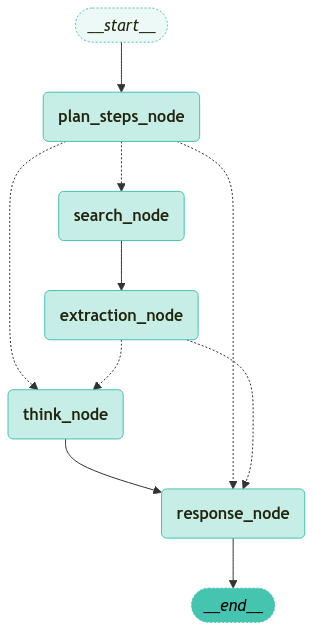

In [12]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(graph)

In [13]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("=" * 60)

                # 쿼리 정보가 있으면 출력
                tool_calls = chunk_msg.additional_kwargs.get("tool_calls", [])
                if tool_calls:
                    # print(f"🔍 Query: ", end="")
                    for tool_call in tool_calls:
                        query = tool_call.get("function", {}).get("arguments", "")
                        if query:

                            print(f"{query}", end="", flush=True)
                else:
                    # 쿼리 정보가 없으면 content 출력
                    content = chunk_msg.content
                    if content:
                        print(content, end="", flush=True)

            prev_node = curr_node

In [14]:
config = {
    "configurable": {
        "thread_id": 11,  # temporary thread ID for testing
    },
}

inputs = AgentState(
    messages=[
        HumanMessage(
            content="How did the implementation of artificial intelligence in supply chain management during the COVID-19 pandemic impact global trade efficiency, and what are the current trends and future projections for AI-driven supply chains in the next decade?"
        )
    ],
    steps=[],
    answer=None,
)

In [15]:
await astream_graph(graph, inputs, config=config)


🔄 Node: plan_steps_node 🔄
{"steps":[{"id":"search_1","description":"Search for information on the impact of AI in supply chain management during the COVID-19 pandemic on global trade efficiency.","status":"pending","type":"search","search_result":null,"result":null},{"id":"search_2","description":"Search for current trends in AI-driven supply chains as of 2025.","status":"pending","type":"search","search_result":null,"result":null},{"id":"search_3","description":"Search for future projections for AI in supply chain management over the next decade.","status":"pending","type":"search","search_result":null,"result":null},{"id":"think_1","description":"Analyze the information retrieved from the searches to identify key impacts, trends, and projections.","status":"pending","type":"think","search_result":null,"result":null},{"id":"respond_1","description":"Generate a comprehensive response summarizing the findings in markdown format.","status":"pending","type":"respond","search_result":null

In [16]:
graph.get_state(config).values

{'messages': [HumanMessage(content='How did the implementation of artificial intelligence in supply chain management during the COVID-19 pandemic impact global trade efficiency, and what are the current trends and future projections for AI-driven supply chains in the next decade?', additional_kwargs={}, response_metadata={}, id='200fd9c9-1a96-433d-8a9b-55b54c54dd1c')],
 'steps': [TaskStep(id='search_1', description='Search for information on the impact of AI in supply chain management during the COVID-19 pandemic on global trade efficiency.', status='completed', type='search', data={}, search_result=None, result=None),
  TaskStep(id='search_2', description='Search for current trends in AI-driven supply chains as of 2025.', status='completed', type='search', data={}, search_result=None, result=None),
  TaskStep(id='search_3', description='Search for future projections for AI in supply chain management over the next decade.', status='completed', type='search', data={}, search_result=None

In [18]:
from IPython.display import Markdown

Markdown(graph.get_state(config).values["answer"].markdown)

## Impact of AI in Supply Chain Management During COVID-19

The COVID-19 pandemic significantly disrupted global trade, leading to delays, shortages, and increased costs. In response, many companies accelerated the implementation of artificial intelligence (AI) in their supply chain management. AI technologies, such as predictive analytics, machine learning, and automation, played a crucial role in enhancing supply chain efficiency by enabling better demand forecasting, optimizing inventory levels, and improving logistics operations. This shift not only mitigated some of the pandemic's adverse effects but also improved overall resilience and adaptability in supply chains, thereby enhancing global trade efficiency during a turbulent time[1].

## Current Trends in AI-Driven Supply Chains (as of 2025)

As of 2025, several key trends have emerged in AI-driven supply chains:
1. **Increased Automation**: Companies are increasingly adopting AI-driven automation solutions to streamline operations and reduce human error.
2. **Enhanced Data Analytics**: The use of big data combined with AI is helping organizations gain deeper insights into supply chain dynamics, enabling more informed decision-making.
3. **Sustainability Focus**: AI is being leveraged to optimize supply chains for sustainability, helping companies reduce waste and improve energy efficiency.
4. **Real-Time Monitoring**: AI technologies are facilitating real-time monitoring of supply chain processes, allowing for quicker responses to disruptions[2].

## Future Projections for AI in Supply Chain Management (Next Decade)

Looking ahead to the next decade, several projections can be made regarding AI in supply chain management:
- **Widespread Adoption**: AI is expected to become a standard component of supply chain strategies, with most organizations leveraging AI technologies to enhance efficiency and responsiveness.
- **Integration with IoT**: The integration of AI with the Internet of Things (IoT) will lead to smarter supply chains, where connected devices provide real-time data for better decision-making.
- **Advanced Predictive Capabilities**: AI will continue to evolve, offering more advanced predictive capabilities that will help companies anticipate market changes and consumer behavior more accurately.
- **Greater Collaboration**: AI will facilitate enhanced collaboration across supply chain partners, leading to more integrated and transparent supply chain ecosystems[3].

In summary, the implementation of AI in supply chain management during the COVID-19 pandemic significantly improved global trade efficiency, and current trends indicate a strong future for AI-driven supply chains, characterized by increased automation, data analytics, sustainability, and real-time monitoring.

---

[1]: [Impact of AI on Supply Chains during COVID-19](http://example.com/impact-ai-covid)
[2]: [Trends in AI-Driven Supply Chains 2025](http://example.com/trends-ai-supply-chain)
[3]: [Future Projections for AI in Supply Chains](http://example.com/future-ai-supply-chain)

In [20]:
pprint(graph.get_state(config).values["answer"].references)

[Reference(citation_id=1, title='Impact of AI on Supply Chains during COVID-19', url='http://example.com/impact-ai-covid'),
 Reference(citation_id=2, title='Trends in AI-Driven Supply Chains 2025', url='http://example.com/trends-ai-supply-chain'),
 Reference(citation_id=3, title='Future Projections for AI in Supply Chains', url='http://example.com/future-ai-supply-chain')]
